In [85]:
import sys
!{sys.executable} -m pip install plotly

     --------------------------------------- 15.3/15.3 MB 59.5 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sys
!{sys.executable} -m pip install tqdm"

     ---------------------------------------- 78.5/78.5 kB 4.3 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [86]:
import pandas as pd
import numpy as np
from datetime import datetime

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

#others
from tqdm import tqdm

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)
pd.options.plotting.backend = "plotly"

In [69]:
calendar = pd.read_csv('calendar.csv')
listing = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

In [10]:
reviews.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...


Q1: Is there any special pattern of 'busy' season where occupancy rate is significantly higher than usual?

In [70]:
calendar['datetime'] = calendar['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
calendar['year-month'] = calendar['date'].apply(lambda x: x[0:7])

#Monday -> 0; Sunday -> 6
calendar['weekday'] = calendar['datetime'].apply(lambda x: x.weekday())
calendar['year'] = calendar['datetime'].apply(lambda x: x.year)
calendar['month'] = calendar['datetime'].apply(lambda x: x.month)
calendar['if_weekends'] = calendar['weekday'].apply(lambda x: 1 if x==5 or x==6 else 0)

calendar['if_booked'] = calendar['available'].map({'f':1,'t':0})

Text(0.5, 1.0, 'Overall Book Rate By year-month')

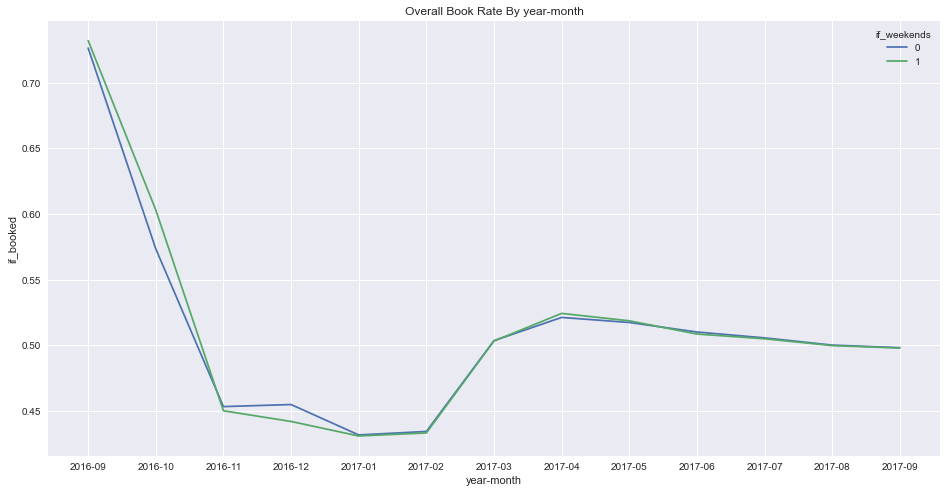

In [117]:
group = calendar[['if_booked','year-month','if_weekends']].groupby(['year-month','if_weekends'])
agg = group.aggregate({'if_booked':pd.Series.mean})
agg = agg.reset_index()

sns.lineplot(data=agg,
             x='year-month', 
             y='if_booked', 
             hue='if_weekends', 
             legend='full')

# add title
plt.title('Overall Book Rate By year-month')

In [118]:
calendar['week_num']=calendar['datetime'].apply(lambda x: x.isocalendar().week)

Text(0.5, 1.0, 'Overall Book Rate By week_num')

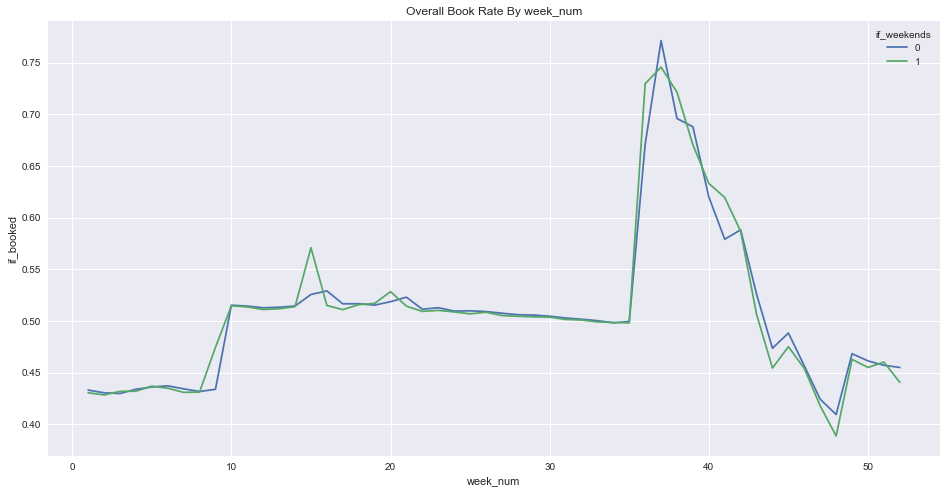

In [121]:
group = calendar[['if_booked','week_num','if_weekends']].groupby(['week_num','if_weekends'])
agg = group.aggregate({'if_booked':pd.Series.mean})
agg = agg.reset_index()

sns.lineplot(data=agg,
             x='week_num', 
             y='if_booked', 
             hue='if_weekends', 
             legend='full')

# add title
plt.title('Overall Book Rate By week_num')

Q2: does this 'busy' season pattern different among different areas of the city?

In [129]:
listing_basic = listing[['id','zipcode','price','city','neighbourhood','square_feet']]

In [136]:
cal_list = calendar.merge(listing_basic, left_on='listing_id',right_on='id', how='left')

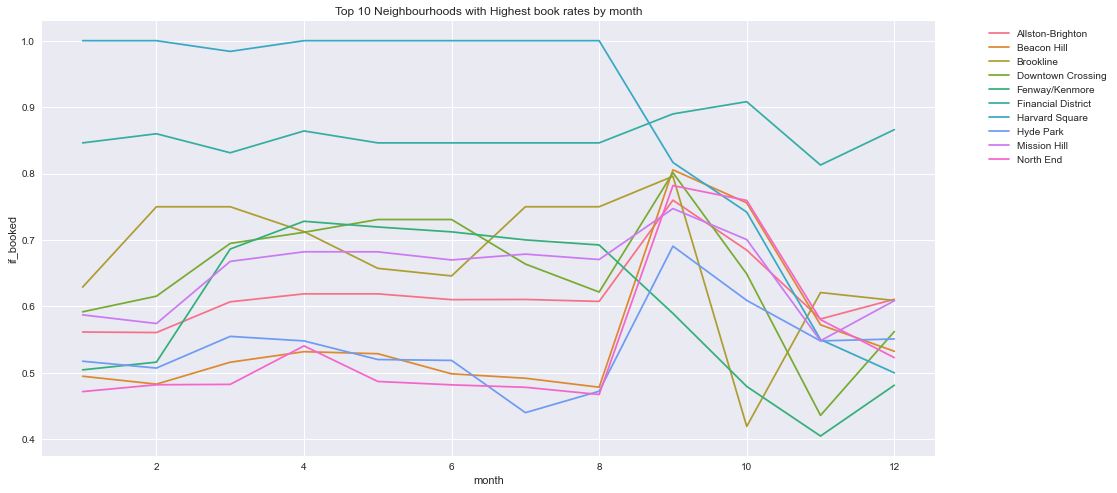

In [171]:
group = cal_list[['if_booked','month','neighbourhood']].groupby(['month','neighbourhood'])
agg = group.aggregate({'if_booked':pd.Series.mean})
agg = agg.reset_index()

top_10_n = agg.groupby('neighbourhood').aggregate({'if_booked': pd.Series.mean}).sort_values('if_booked', ascending=False)[0:10].index
top_10_data = agg[agg.neighbourhood.isin(top_10_n)]

palette = sns.color_palette('husl', 10)
sns.lineplot(data=top_10_data,
             x='month', 
             y='if_booked', 
             hue='neighbourhood',
             palette=palette, 
             legend='full')

# add title
plt.title('Top 10 Neighbourhoods with Highest book rates by month')
# move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

Answer: No, different neighbourhoods do not share the same pattern of 'busy' season. In Sep, most of the areas have spike in book rate while 'harvard Square' experienced a drop. Likewise, In Dec, it drops while most of the other neightbourhoods experienced a spike. 

Q3: Where's the most expensive area?

In [183]:
cal_list_price_int = cal_list.price.map(lambda x: x.replace('$','').replace(',',''), na_action ='ignore')
cal_list['price'] = cal_list_price_int.astype(float)

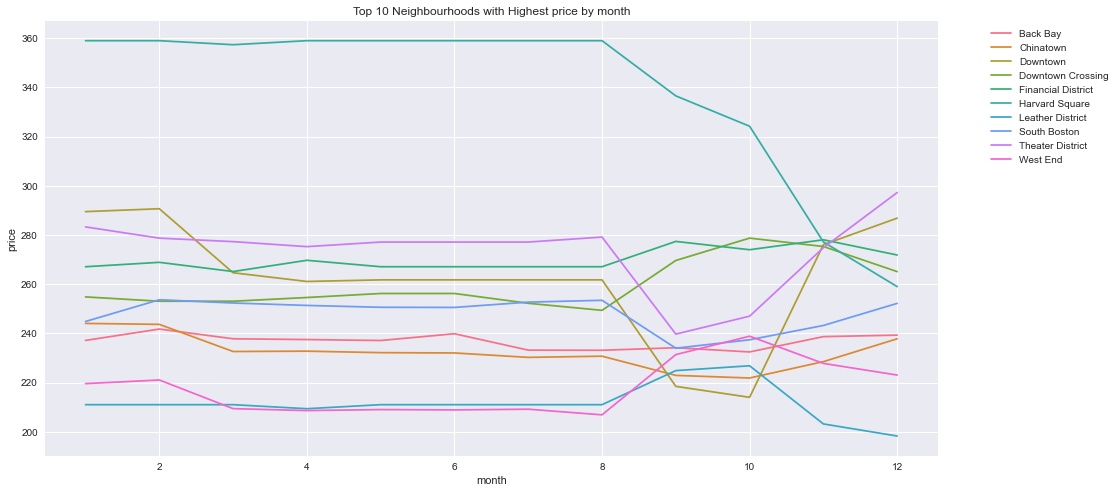

In [188]:
cond = cal_list.if_booked==1
group = cal_list[cond][['price','month','neighbourhood']].groupby(['month','neighbourhood'])
agg = group.aggregate({'price':pd.Series.mean})
agg = agg.reset_index()

top_10_n = agg.groupby('neighbourhood').aggregate({'price': pd.Series.mean}).sort_values('price', ascending=False)[0:10].index
top_10_data = agg[agg.neighbourhood.isin(top_10_n)]

palette = sns.color_palette('husl', 10)
sns.lineplot(data=top_10_data,
             x='month', 
             y='price', 
             hue='neighbourhood',
             palette=palette, 
             legend='full')

# add title
plt.title('Top 10 Neighbourhoods with Highest price by month')
# move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);